<h2>Layer activations of the Movsisyans Singularity eXtracting Convolutional Network (MSXCN)</h2>

## 1 - Importing Tools and Data

In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
import matplotlib.patches as patches
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keract import get_activations, display_heatmaps, display_activations
from keras.layers.experimental.preprocessing import RandomTranslation, RandomRotation, RandomWidth, RandomHeight, RandomZoom, Resizing
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Reshape, GlobalAveragePooling2D, LeakyReLU, Layer, Concatenate, Input


seed = 173
np.random.seed(seed)
tf.random.set_seed(seed)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10781274553559214536
]


In [2]:
df = pd.read_csv("data/drawings_non_binary.csv")
mnist = pd.read_csv("data/train.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## 2 - Joining Data

In [3]:
joint = pd.DataFrame(mnist.iloc[:, 1:].to_numpy())
joint["label"] = mnist.label
jointDf = pd.DataFrame(np.concatenate((joint, df), axis=0)).rename({784: "label"}, axis=1).sample(frac=1, random_state=seed)

In [4]:
y = to_categorical(jointDf.label)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(jointDf.iloc[:,:-1], y, train_size=0.9, random_state=seed) # no need to stratify for large balanced datasets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42759, 784), (4751, 784), (42759, 10), (4751, 10))

In [6]:
class SingularityExtractor2D(Layer):
    """
    Accentuates pixels that differ from its surrounding pixels. 
    """

    def __init__(self, degree=6, kernel_size=3, padding="SYMMETRIC", margin=1, **kwargs):
        if not ((kernel_size % 2) and kernel_size >= 3 and isinstance(kernel_size, int)):
            raise ValueError("kernel_size: value must be odd, >= 3")

        if not (margin >= 1 and isinstance(margin, int)):
            raise ValueError("margin: must be integer >= 1")

        if padding not in ["CONSTANT", "SYMMETRIC", "REFLECT"]:
            raise ValueError(
                "padding: must be one of ['CONSTANT', 'SYMMETRIC', 'REFLECT']")

        self.degree = degree
        self.kernel_size = kernel_size
        self.padding = padding
        self.margin = margin

        self.radius = int((kernel_size - 1)/2)
        
        if "trainable" in kwargs.keys():
            super(SingularityExtractor2D, self).__init__(**kwargs)
        else:
            super(SingularityExtractor2D, self).__init__(trainable = False, **kwargs)

    # region Keras api

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError("input must be 4D (batch_size, x, y, channels)")

        super(SingularityExtractor2D, self).build(input_shape)

        # Lazy load conv kernel
        self.ones = tf.ones((self.kernel_size, self.kernel_size, input_shape[-1], input_shape[-1]))

    def get_config(self):
        """Layer to dict = serializability"""

        config = super(SingularityExtractor2D, self).get_config()
        config["degree"] = self.degree
        config["kernel_size"] = self.kernel_size
        config["padding"] = self.padding
        config["margin"] = self.margin
        config["dtype"] = self.dtype

        return config

    @classmethod
    def from_config(cls, config):
        return cls(
            config["degree"],
            config["kernel_size"],
            config["padding"],
            config["margin"],
            dtype=config["dtype"]
        )

    def call(self, input_data):
        return self.extract(input_data, "keras")

    # endregion Keras api

    # region Scikit api

    def fit(self, x, *args, **kwargs):
        if len(x.shape) != 4:
            raise ValueError(
                "input must be 4D (number_of_observations, x, y, 1)")

    def transform(self, input_data, *args, **kwargs):
        return self.extract(input_data, "sk")

    # endregion Scikit api

    def extract(self, input_data, api):
        if api == "sk":
            self.extract(input_data, "keras").numpy()
        else:
            # Pad the incoming tensor
            matpad = tf.pad(input_data, [
                [0, 0],
                [self.radius, self.radius],
                [self.radius, self.radius],
                [0, 0]
            ], mode=self.padding)

            # Sum all the pixels in the kernel
            conv = tf.nn.convolution(matpad, self.ones, 1, padding="SAME")

            # Calculate the change in shape
            mrgn_0 = int((conv.shape[1] - input_data.shape[1])/2) + self.margin
            mrgn_1 = int((conv.shape[2] - input_data.shape[2])/2) + self.margin

            # Select appropriate regions
            selection_conv = conv[:, mrgn_0:-mrgn_0, mrgn_1:-mrgn_1, :]
            selection_input = input_data[:, self.margin:-
                                         self.margin, self.margin:-self.margin, :]

            # Compute the output
            return ((selection_conv - selection_input) / selection_conv) ** self.degree


In [7]:
class PreprocessingBlock(Layer):
    """Preprocessing block (width, translation, zoom, seed=173)"""

    def __init__(self, width, translation, zoom, seed=173, **kwargs):
        super(PreprocessingBlock, self).__init__(**kwargs)
        self.w, self.t, self.z, self.s = width, translation, zoom, seed
        self.reshape = Reshape((28, 28, 1))
        self.width = RandomWidth(width, seed=seed, interpolation="bicubic")
        self.translation = RandomTranslation(
            *translation, seed=seed, fill_mode="constant", fill_value=0)
        self.zoom = RandomZoom(*zoom, seed=seed)
        self.resize = Resizing(28, 28, interpolation="bicubic")

    def call(self, input_data, training=None):
        x = self.reshape(input_data)

        if training:
            x = self.width(x)
            x = self.translation(x)
            x = self.zoom(x)
            x = self.resize(x)

        return x
    
    def get_config(self):
        config = super(PreprocessingBlock, self).get_config()
        config["width"] = self.w
        config["translation"] = self.t
        config["zoom"] = self.z
        config["seed"] = self.s
        
        return config
        
    @classmethod
    def from_config(cls, config):
        cls(**config)

In [8]:
class ConvBlock(Layer):
    """A block of convolutional layers"""

    def __init__(self, units, kernel_size, depth, pool=False, seed=173, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.units = units
        self.kernel_size = kernel_size
        self.depth = depth
        self.pool = pool
        self.seed = seed
        self.layers = []

        for i in range(depth - 1):
            self.layers.append(
                Conv2D(units, kernel_size=kernel_size, padding="same", activation="relu"))
            self.layers.append(BatchNormalization(axis=1))

        if pool:
            self.layers.append(
                Conv2D(units, kernel_size=kernel_size, padding="same", activation="relu"))
            self.layers.append(MaxPool2D())
        else:
            self.layers.append(Conv2D(
                units, kernel_size=kernel_size, padding="same", strides=2, activation="relu"))

    def call(self, input_data):
        out = input_data
        for layer in self.layers:
            out = layer(out)
        return out
    
    def get_config(self):
        config = super(ConvBlock, self).get_config()
        config["units"] = self.units
        config["kernel_size"] = self.kernel_size
        config["depth"] = self.depth
        config["pool"] = self.pool
        config["seed"] = self.seed
        
        return config
        
    @classmethod
    def from_config(cls, config):
        cls(**config)
        

In [9]:
def get_model(seed=173):
    """Generate MSXCN"""
    
    x = Input((28 * 28))
    y = PreprocessingBlock(0.18, (0.14, 0.2), ((-0.05, -0.1), (-0.05, -0.02)), seed=seed)(x)


    # Convolutional chain
    y_0_0 = ConvBlock(32, 5, 2, True, seed=seed)(y)
    y_0 = BatchNormalization(axis=1)(y_0_0) # Some papers suggest to stay away from
    y_0 = Dropout(0.3, seed=seed)(y_0)      # using batch-norm and dropout together
                                            # https://link.springer.com/article/10.1007/s11042-019-08453-9
        
    y_0 = ConvBlock(64, 5, 2, True, seed=seed)(y_0)
    y_0 = BatchNormalization(axis=1)(y_0)
    y_0 = Dropout(0.3, seed=seed)(y_0)

    
    y_0 = ConvBlock(128, 5, 2, True, seed=seed)(y_0)
    y_0 = GlobalAveragePooling2D()(y_0)
    y_0 = Flatten()(y_0)
    y_0 = BatchNormalization(axis=1)(y_0)
    y_0 = Dropout(0.4, seed=seed)(y_0)
    
    
    
    # Singularity Extractor chain 1
    y_1 = SingularityExtractor2D(6, 5, margin=1)(y)
    y_1 = LeakyReLU(0)(y_1)
    y_1 = SingularityExtractor2D(6, 5, margin=1)(y_1)
    y_1 = LeakyReLU(0)(y_1)
    y_1 = SingularityExtractor2D(6, 5, margin=1)(y_1)
    y_1 = LeakyReLU(0)(y_1)
    y_1 = Conv2D(64, kernel_size=11, padding="same", activation="relu")(y_1)
    y_1 = MaxPool2D()(y_1)
    y_1 = Flatten()(y_1)
    y_1 = BatchNormalization(axis=1)(y_1)
    


    # Cognitive block
    y = Concatenate()([y_0, y_1])
    y = Dense(1024)(y)
    y = LeakyReLU(0.1)(y)
    y = BatchNormalization(axis=1)(y)
    y = Dropout(0.5, seed=seed)(y)

    y = Dense(2048, activation="tanh")(y)
    y = BatchNormalization(axis=1)(y)
    y = Dropout(0.65, seed=seed)(y)

    y = Dense(10, activation="softmax")(y)

    opt = RMSprop(learning_rate = 0.002, decay = 0)
    model = tf.keras.Model(x, y)
    model.compile(opt, "categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [10]:
model = get_model()
model.load_weights("model/checkpoint.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
preprocessing_block (Preprocess (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, 14, 14, 32)   26576       preprocessing_block[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 32)   56          conv_block[0][0]                 
______________________________________________________________________________________________

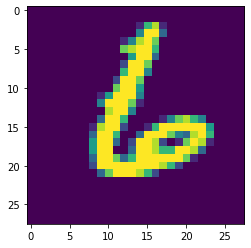

In [12]:
plt.imshow(np.array(x_train.iloc[900]/255).reshape(28,28));

In [13]:
from keract import get_activations, display_heatmaps
activations = get_activations(model, np.array(x_train.iloc[900]/255).reshape(1, 784))

In [14]:
activations.keys()

odict_keys(['input_1', 'preprocessing_block', 'conv_block', 'batch_normalization_1', 'singularity_extractor2d', 'dropout', 'leaky_re_lu', 'conv_block_1', 'singularity_extractor2d_1', 'batch_normalization_3', 'leaky_re_lu_1', 'dropout_1', 'singularity_extractor2d_2', 'conv_block_2', 'leaky_re_lu_2', 'global_average_pooling2d', 'conv2d_6', 'flatten', 'max_pooling2d_3', 'batch_normalization_5', 'flatten_1', 'dropout_2', 'batch_normalization_6', 'concatenate', 'dense', 'leaky_re_lu_3', 'batch_normalization_7', 'dropout_3', 'dense_1', 'batch_normalization_8', 'dropout_4', 'dense_2'])

In [15]:
display_activations(activations = activations, save = True, directory="model", cmap="gray")

input_1 (1, 784) 
preprocessing_block (1, 28, 28, 1) 
conv_block (1, 14, 14, 32) 
batch_normalization_1 (1, 14, 14, 32) 
singularity_extractor2d (1, 26, 26, 1) 
dropout (1, 14, 14, 32) 
leaky_re_lu (1, 26, 26, 1) 
conv_block_1 (1, 7, 7, 64) 
singularity_extractor2d_1 (1, 24, 24, 1) 
batch_normalization_3 (1, 7, 7, 64) 
leaky_re_lu_1 (1, 24, 24, 1) 
dropout_1 (1, 7, 7, 64) 
singularity_extractor2d_2 (1, 22, 22, 1) 
conv_block_2 (1, 3, 3, 128) 
leaky_re_lu_2 (1, 22, 22, 1) 
global_average_pooling2d (1, 128) 
conv2d_6 (1, 22, 22, 64) 


C:\Users\zolobrine\AppData\Roaming\Python\Python39\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\zolobrine\AppData\Roaming\Python\Python39\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\zolobrine\AppData\Roaming\Python\Python39\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


flatten (1, 128) 
max_pooling2d_3 (1, 11, 11, 64) 


C:\Users\zolobrine\AppData\Roaming\Python\Python39\site-packages\matplotlib\colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


batch_normalization_5 (1, 128) 
flatten_1 (1, 7744) 
dropout_2 (1, 128) 
batch_normalization_6 (1, 7744) 
concatenate (1, 7872) 
dense (1, 1024) 
leaky_re_lu_3 (1, 1024) 
batch_normalization_7 (1, 1024) 
dropout_3 (1, 1024) 
dense_1 (1, 2048) 
batch_normalization_8 (1, 2048) 
dropout_4 (1, 2048) 
dense_2 (1, 10) 
